<a href="https://colab.research.google.com/github/williamvalenciaK/SQLServerPIT/blob/main/Clases/2_Sesi%C3%B3n_4_TRIGGERS_O_DESENCADENANTES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table width='99%'>
<tr>
<td bgcolor='#52008E'>

# **<font color="#FFFFFF"> ◉ TRIGGERS O DESENCADENANTES</font>**

</td>
</tr>
</table>

Los triggers DDL se pueden usar para auditar las operaciones de base de datos o de servidor que crean, modifican o eliminan objetos de base de datos o garantizar que las instrucciones DDL aplican las reglas de negocios antes de que se ejecuten.

Los triggers DDL se inician en respuesta a una variedad de eventos de lenguaje de definición de datos (DDL). Estos eventos corresponden principalmente a las instrucciones Transact SQL que comienzan por las palabras clave CREATE, ALTER, DROP, GRANT, DENY, REVOKE o UPDATE STATISTICS.

Algunos procedimientos almacenados del sistema que ejecutan operaciones de tipo DDL también pueden activar triggers DDL.

**Importante**

Los triggers DDL se pueden utilizar para verificar la respuesta a los procedimientos almacenados del sistema. Por ejemplo, la sentencia CREATE TYPE y el procedimiento almacenado SP_ADDTYPE
activarán un trigger DDL activado por el evento CREATE_TYPE.

Cuando usar triggers DDL:

>* Para evitar determinados cambios en el esquema de la base de datos.
>* Se quiere que ocurra algún evento en la base de datos como respuesta a un cambio realizado en el esquema de la base de datos.
>* Se quiere registrar cambios o eventos del esquema de la base de datos.

<table width='99%'>
<tr>
<td bgcolor='#FFC901'>

## **<font color="#000000"> ◉ TIPOS DE TRIGGERS DDL</font>**

</td>
</tr>
</table>

<table width='99%'>
<tr>
<td bgcolor='#BB2125'>

### **<font color="#FFFFFF"> ◉ Trigger Transact-SQL DDL </font>**

</td>
</tr>
</table>

Se trata de un tipo especial de procedimiento almacenado de Transact-SQL que ejecuta una o más instrucciones Transact-SQL en respuesta a un evento de servidor o de base de datos.

Por ejemplo, un trigger DDL se puede activar si se ejecuta una instrucción como ALTER SERVER CONFIGURATION o si se elimina una tabla mediante DROP TABLE.


<table width='99%'>
<tr>
<td bgcolor='#BB2125'>

### **<font color="#FFFFFF"> ◉ Desencadenante CLR DLL</font>**

</td>
</tr>
</table>

En lugar de ejecutar un procedimiento almacenado Transact-SQL, un trigger CLR ejecuta uno o más métodos escritos en código administrado que son miembros de un ensamblado creado en .NET Framework y cargado en SQL Server.

<table width='99%'>
<tr>
<td bgcolor='#BB2125'>

### **<font color="#FFFFFF"> ◉ Trigger Transact-SQL DML (INSERT, UPDATE, DELETE) </font>**

</td>
</tr>
</table>

Los Triggers Transact-SQL DML (Data Manipulation Language) son un tipo especial de objeto de base de datos en SQL Server que se ejecutan automáticamente cuando se produce una operación de inserción (INSERT), actualización (UPDATE) o eliminación (DELETE) en una tabla específica.

<table width='99%'>
<tr>
<td bgcolor='#1F9186'>

#### **<font color="#FFFFFF"> ◉ Características</font>**

</td>
</tr>
</table>

>* **Activación Automática**: Los triggers DML se activan de manera automática cuando se realiza una operación DML en la tabla asociada, sin necesidad de ser llamados explícitamente.
>* **Acceso a Datos Afectados**: Los triggers tienen acceso a los datos que se están insertando, actualizando o eliminando, a través de las tablas especiales **inserted** y **deleted**.
>* **Validación y Lógica de Negocio**: Los triggers se utilizan comúnmente para implementar reglas de negocio, validaciones y lógica de control de flujo adicional a la operación DML.
>* **Tipos de Triggers DML**: Existen tres tipos de triggers DML: INSERT, UPDATE y DELETE, que se activan según la operación realizada.

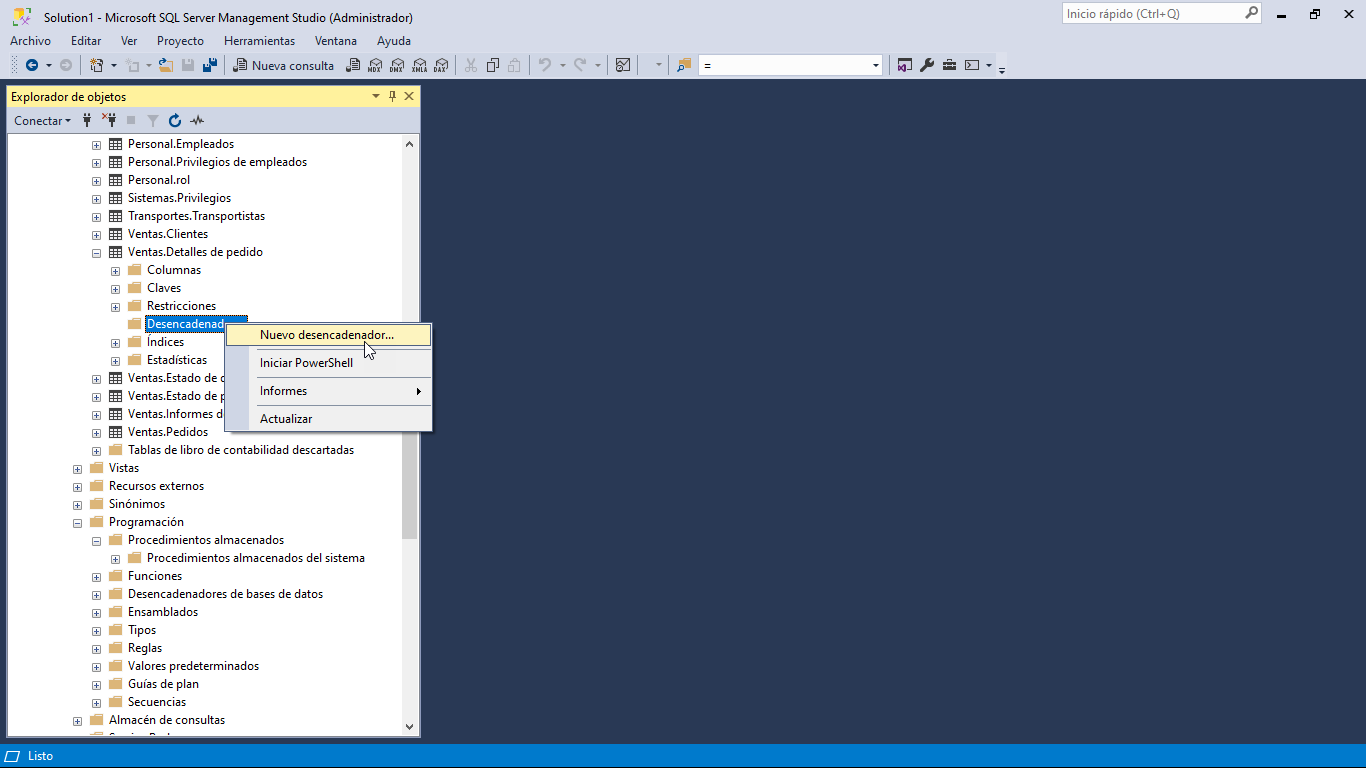

<table width='99%'>
<tr>
<td bgcolor='#1F9186'>

#### **<font color="#FFFFFF"> ◉ Trigger por inserción</font>**

</td>
</tr>
</table>



```
USE [NorthwindSQL]
GO
/****** Object:  Trigger [Ventas].[utr_detalles_de_pedido_x_insert]    Script Date: 9/08/2024 12:35:18 ******/
SET ANSI_NULLS ON
GO
SET QUOTED_IDENTIFIER ON
GO
-- =============================================
-- Author:		Edgard Lucho
-- Create date: 09/08/2024
-- Description:	Trigger por inserción
-- =============================================
CREATE TRIGGER [Ventas].[utr_ventas_detalles_de_pedido_insert]
   ON  [Ventas].[Detalles de pedido]
   AFTER INSERT
AS
BEGIN
	SET NOCOUNT ON;

	DECLARE @Id						int
	DECLARE @Id_de_pedido			int
	DECLARE @Id_de_producto			int
	DECLARE @Cantidad				decimal(18, 4)
	DECLARE @Precio					money
	DECLARE @Descuento				float
	DECLARE @Id_de_situacion		int
	DECLARE @Fecha_de_asignacion	datetime
	DECLARE @Id_de_pedido_de_compra	int
	DECLARE @Id_de_inventario		int

	DECLARE @Stock					int

	DECLARE @Costo_estandar			money
	DECLARE @Precio_listado			money
	DECLARE @Suspendido				bit

	DECLARE @msg					varchar(8000)

	DECLARE @ErrorNumber			int
	DECLARE @ErrorSeverity			int
	DECLARE @ErrorState				int
	DECLARE @ErrorProcedure			nvarchar(128)
	DECLARE @ErrorLine				int
	DECLARE @ErrorMessage			nvarchar(4000)
	DECLARE @ErrorDate				datetime

	BEGIN TRY
		SELECT
			@Id = [Id]
			,@Id_de_pedido = [Id de pedido]
			,@Id_de_producto = [Id de producto]
			,@Cantidad = [Cantidad]
			,@Precio = [Precio]
			,@Descuento = [Descuento]
			,@Id_de_situacion = [Id de situación]
			,@Fecha_de_asignacion = [Fecha de asignación]
			,@Id_de_pedido_de_compra = [Id de pedido de compra]
			,@Id_de_inventario = [Id de inventario]
		FROM inserted
		SELECT
				@Stock =
				SUM
				(
					CONVERT
					(
						INT,
						CASE ti.[Tipo de transacción]
							WHEN 1 THEN '+'
							WHEN 2 THEN '-'
							WHEN 3 THEN '-'
							WHEN 4 THEN '+'
						END + LTRIM(ti.Cantidad)
					)
				)
			FROM [Almacen].[Productos] p
			INNER JOIN [Almacen].[Transacciones de inventario] ti
			ON p.Id = ti.[Id de producto]
			WHERE p.id = @Id_de_producto
			GROUP BY p.id;

			SELECT
				@Costo_estandar = [Costo estándar]
				,@Precio_listado = [Precio listado]
				,@Suspendido = [Suspendido]
			FROM [Almacen].[Productos]
			WHERE [Id] = @Id_de_producto

			IF @Cantidad > @Stock
			BEGIN
				SET @msg = 'ERROR: La cantidad solicitada ' + LTRIM(@Cantidad) +' es mayor que el stock: ' + LTRIM(@Stock);
				THROW 51001, @msg , 1;
			END

			IF NOT(@Precio * (1 - @Descuento) > @Costo_estandar AND @Precio*(1 - @Descuento) <= @Precio_listado)
			BEGIN
				SET @msg = 'ERROR: ' + LTRIM(@Costo_estandar) + '<' + LTRIM(@Precio * (1 - @Descuento)) +' <= ' + LTRIM(@Precio_listado);
				THROW 51002, @msg , 1;
			END

			IF @Suspendido <> 0
			BEGIN
				SET @msg = 'ERROR: PRODUCTO DESCONTINUADO';
				THROW 51003, @msg , 1;
			END

			INSERT INTO [Almacen].[Transacciones de inventario]
			(
				[Tipo de transacción]
				,[Fecha de creación de la transacción]
				,[Fecha modificada de la transacción]
				,[Id de producto]
				,[Cantidad]
				,[Id de pedido de compra]
				,[Id de pedido de cliente]
				,[Comentarios]
			)
			VALUES
			(
			   2
			   ,@Fecha_de_asignacion
			   ,GETDATE()
			   ,@Id_de_producto
			   ,@Cantidad
			   ,NULL
			   ,@Id_de_pedido
			   ,NULL
			)
		END TRY
		BEGIN CATCH
			SELECT  
				@ErrorNumber = ERROR_NUMBER()
				,@ErrorSeverity = ERROR_SEVERITY()
				,@ErrorState = ERROR_STATE()
				,@ErrorProcedure = ERROR_PROCEDURE()
				,@ErrorLine = ERROR_LINE()
				,@ErrorMessage = ERROR_MESSAGE()
				,@ErrorDate = GETDATE()

			ROLLBACK TRANSACTION

			INSERT INTO [dbo].[tbl_error_usp]
			(
				[ErrorNumber]
				,[ErrorSeverity]
				,[ErrorState]
				,[ErrorProcedure]
				,[ErrorLine]
				,[ErrorMessage]
				,[ErrorDate]
			)
			VALUES
			(
				@ErrorNumber
				,@ErrorSeverity
				,@ErrorState
				,@ErrorProcedure
				,@ErrorLine
				,@ErrorMessage
				,@ErrorDate
			)
		END CATCH
END
```



<table width='99%'>
<tr>
<td bgcolor='#1F9186'>

#### **<font color="#FFFFFF"> ◉ Trigger por modificación</font>**

</td>
</tr>
</table>



```
SET ANSI_NULLS ON
GO
SET QUOTED_IDENTIFIER ON
GO
-- =============================================
-- Author:		Edgard Lucho
-- Create date: 09/08/2024
-- Description:	Trigger por actualización
-- =============================================
CREATE TRIGGER Ventas.utr_ventas_detalles_de_pedido_actualizacion
   ON  Ventas.[Detalles de pedido]
   AFTER UPDATE
AS
BEGIN
	SET NOCOUNT ON;
	BEGIN TRY
		DECLARE @ErrorNumber			int
		DECLARE @ErrorSeverity			int
		DECLARE @ErrorState				int
		DECLARE @ErrorProcedure			nvarchar(128)
		DECLARE @ErrorLine				int
		DECLARE @ErrorMessage			nvarchar(4000)
		DECLARE @ErrorDate				datetime

		DECLARE @Stock					int
		DECLARE @Costo_estandar			money
		DECLARE @Precio_listado			money
		DECLARE @Suspendido				bit
		DECLARE @msg					nvarchar(4000)

		DECLARE @Id_de_inventario		int

		DECLARE @Id_ins							int
		DECLARE @Id_de_pedido_ins				int
		DECLARE @Id_de_producto_ins				int
		DECLARE @Cantidad_ins					decimal(18, 4)
		DECLARE @Precio_ins						money
		DECLARE @Descuento_ins					float
		DECLARE @Id_de_situacion_ins			int
		DECLARE @Fecha_de_asignacion_ins		datetime
		DECLARE @Id_de_pedido_de_compra_ins		int
		DECLARE @Id_de_inventario_ins			int

		DECLARE @Id_del							int
		DECLARE @Id_de_pedido_del				int
		DECLARE @Id_de_producto_del				int
		DECLARE @Cantidad_del					decimal(18, 4)
		DECLARE @Precio_del						money
		DECLARE @Descuento_del					float
		DECLARE @Id_de_situacion_del			int
		DECLARE @Fecha_de_asignacion_del		datetime
		DECLARE @Id_de_pedido_de_compra_del		int
		DECLARE @Id_de_inventario_del			int

		SELECT
			@Id_ins=[Id]
			,@Id_de_pedido_ins=[Id de pedido]
			,@Id_de_producto_ins=[Id de producto]
			,@Cantidad_ins=[Cantidad]
			,@Precio_ins = [Precio]
			,@Descuento_ins = [Descuento]
			,@Id_de_situacion_ins = [Id de situación]
			,@Fecha_de_asignacion_ins = [Fecha de asignación]
			,@Id_de_pedido_de_compra_ins = [Id de pedido de compra]
			,@Id_de_inventario_ins = [Id de inventario]
		FROM inserted;
		PRINT 'OK_1'
		SELECT
			@Id_del=[Id]
			,@Id_de_pedido_del=[Id de pedido]
			,@Id_de_producto_del=[Id de producto]
			,@Cantidad_del=[Cantidad]
			,@Precio_del = [Precio]
			,@Descuento_del = [Descuento]
			,@Id_de_situacion_del = [Id de situación]
			,@Fecha_de_asignacion_del = [Fecha de asignación]
			,@Id_de_pedido_de_compra_del = [Id de pedido de compra]
			,@Id_de_inventario_del = [Id de inventario]
		FROM deleted;
		PRINT 'OK_2'
		SELECT
			@Stock =
			SUM
			(
				CONVERT
				(
					INT,
					CASE ti.[Tipo de transacción]
						WHEN 1 THEN '+'
						WHEN 2 THEN '-'
						WHEN 3 THEN '-'
						WHEN 4 THEN '+'
					END + LTRIM(ti.Cantidad)
				)
			)
		FROM [Almacen].[Productos] p
		INNER JOIN [Almacen].[Transacciones de inventario] ti
		ON p.Id = ti.[Id de producto]
		WHERE p.id = @Id_de_producto_ins
		GROUP BY p.id
		PRINT 'OK_3'
		SELECT
			@Costo_estandar = [Costo estándar]
			,@Precio_listado = [Precio listado]
			,@Suspendido = [Suspendido]
		FROM [Almacen].[Productos]
		WHERE [Id] = @Id_de_producto_ins
		PRINT 'OK_4'
		IF @Cantidad_ins > @Stock + @Cantidad_del
		BEGIN
			SET @msg = 'ERROR: La cantidad solicitada ' + LTRIM(@Cantidad_ins) +' es mayor que el stock: ' + LTRIM(@Stock + @Cantidad_del);
			THROW 51001, @msg , 1;
		END
		PRINT 'OK_5'
		IF NOT(@Costo_estandar < @Precio_ins * (1 - @Descuento_ins) AND @Precio_ins*(1 - @Descuento_ins) <= @Precio_listado)
		BEGIN
			SET @msg = 'ERROR: ' + LTRIM(@Costo_estandar) + '<' + LTRIM(@Precio_ins*(1 - @Descuento_ins)) +' <= ' + LTRIM(@Precio_listado);
			THROW 51002, @msg , 1;
		END
		PRINT 'OK_6'
		IF @Suspendido <> 0
		BEGIN
			SET @msg = 'ERROR: PRODUCTO DESCONTINUADO';
			THROW 51003, @msg , 1;
		END
		PRINT 'OK_7'
		UPDATE [Almacen].[Transacciones de inventario]
		   SET
			  [Fecha modificada de la transacción] = GetDate()
			  ,[Cantidad] = @Cantidad_ins
		WHERE [Id de transacción] = @Id_de_inventario_ins
		PRINT 'OK_8'
	END TRY
	BEGIN CATCH
        SELECT  
            @ErrorNumber = ERROR_NUMBER()
            ,@ErrorSeverity = ERROR_SEVERITY()
            ,@ErrorState = ERROR_STATE()
            ,@ErrorProcedure = ERROR_PROCEDURE()
            ,@ErrorLine = ERROR_LINE()
            ,@ErrorMessage = ERROR_MESSAGE()
            ,@ErrorDate = GETDATE();
		PRINT 'OK_9'
        ROLLBACK TRANSACTION
		PRINT 'OK_10'
        INSERT INTO [dbo].[tbl_error_usp]
        (
            [ErrorNumber]
            ,[ErrorSeverity]
            ,[ErrorState]
            ,[ErrorProcedure]
            ,[ErrorLine]
            ,[ErrorMessage]
            ,[ErrorDate]
        )
        VALUES
        (
            @ErrorNumber
            ,@ErrorSeverity
            ,@ErrorState
            ,@ErrorProcedure
            ,@ErrorLine
            ,@ErrorMessage
            ,@ErrorDate
        )
		PRINT 'OK_11'
    END CATCH
END
GO
```

